Setup:

In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

Imports and setup:

In [2]:
from src.config import get_config
from src.data_loader import load_and_prepare_data
from src.returns import compute_log_returns
from src.correlation import (
    average_pairwise_correlation,
    pca_eigenvalue_share
)
from src.regimes import classify_regimes
from src.portfolios import (
    equal_weight_portfolio,
    mean_variance_portfolio,
    risk_parity_portfolio,
    volatility_targeted_portfolio,
    portfolio_returns
)
from src.risk import (
    sharpe_ratio,
    max_drawdown,
    volatility
)

import pandas as pd
import matplotlib.pyplot as plt

Load Config & Data:

In [3]:
config = get_config()

prices = load_and_prepare_data(
    config["tickers"],
    config["start_date"],
    config["end_date"]
)

prices.head()

,DBC,EEM,EFA,GLD,IEF,SPY,TIP
Date,,,,,,,
2006-01-03,NaN,20.246731,34.152370,53.119999,49.888634,87.463257,56.724670
2006-01-04,NaN,20.430286,34.435951,53.299999,49.977806,87.877464,56.730152
2006-01-05,NaN,20.534231,34.263588,52.340000,49.989689,87.932693,56.565037
2006-01-06,NaN,20.963268,34.725101,53.720001,49.924297,88.664406,56.537510
2006-01-09,NaN,21.168949,34.741783,54.599998,49.948101,88.892204,56.603542


Price Overview Plot:

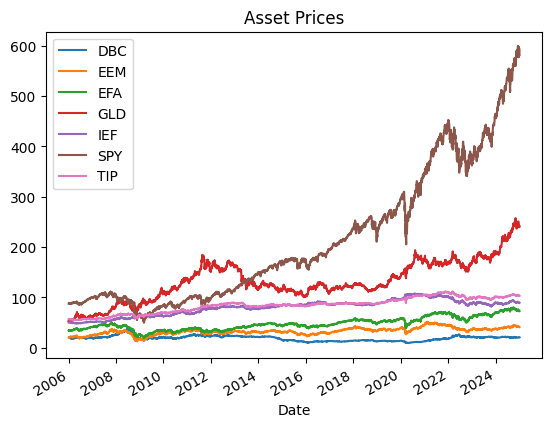

In [4]:
prices.plot(title="Asset Prices")
plt.show()

Compute Returns:

In [5]:
returns = compute_log_returns(prices)
returns.describe()

,DBC,EEM,EFA,GLD,IEF,SPY,TIP
count,4756.000000,4756.000000,4756.000000,4756.000000,4756.000000,4756.000000,4756.000000
mean,0.000015,0.000132,0.000157,0.000304,0.000124,0.000398,0.000125
std,0.012227,0.017848,0.013685,0.011193,0.004369,0.012247,0.003997
min,-0.082778,-0.176334,-0.118369,-0.091905,-0.025393,-0.115886,-0.029977
25%,-0.006339,-0.007922,-0.005427,-0.005166,-0.002478,-0.003977,-0.001897
50%,0.000647,0.000802,0.000660,0.000523,0.000213,0.000673,0.000174
75%,0.006780,0.008451,0.006584,0.006114,0.002640,0.005897,0.002226
max,0.066485,0.205141,0.147451,0.106974,0.033689,0.135577,0.043573


Return Distributions:

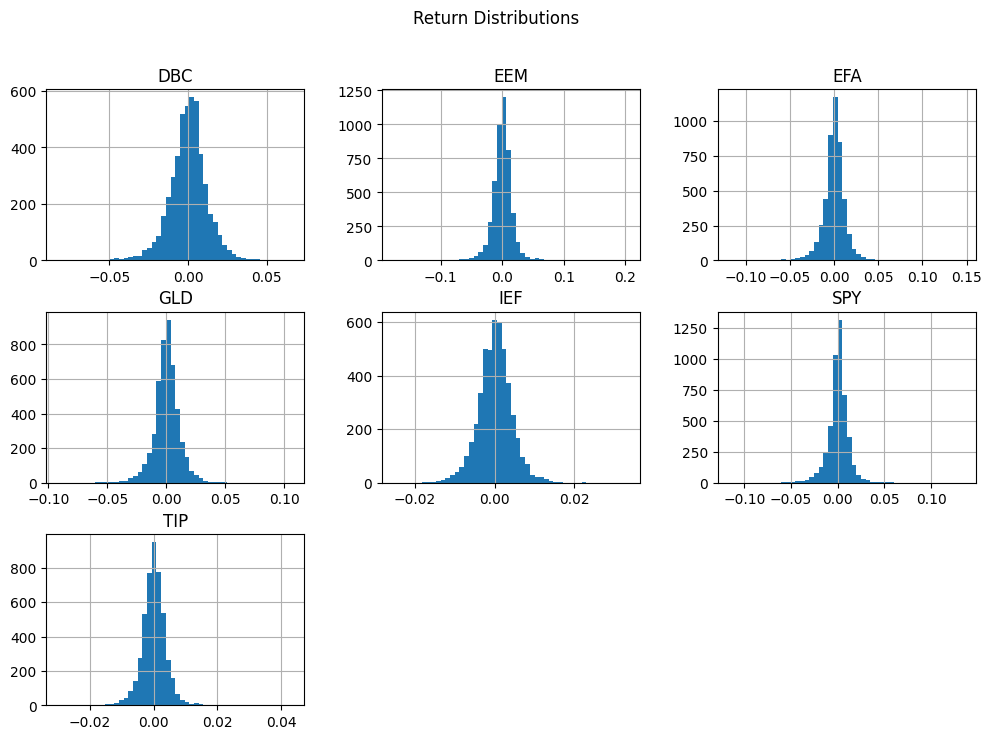

In [6]:
returns.hist(bins=50, figsize=(12, 8))
plt.suptitle("Return Distributions")
plt.show()

Correlation Stress Metrics:

In [7]:
avg_corr = average_pairwise_correlation(
    returns,
    config["rolling_window"]
)

eigen_share = pca_eigenvalue_share(
    returns,
    config["rolling_window"]
)

Correlation Stress Plots:

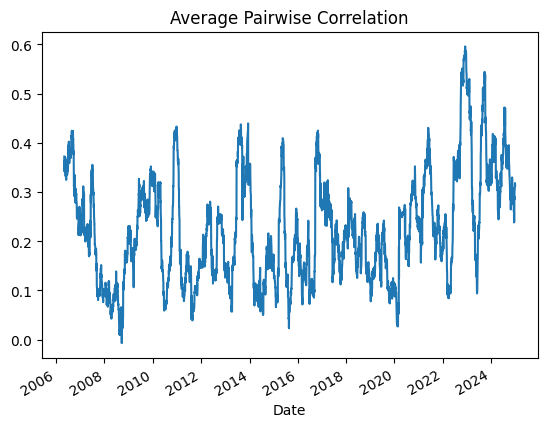

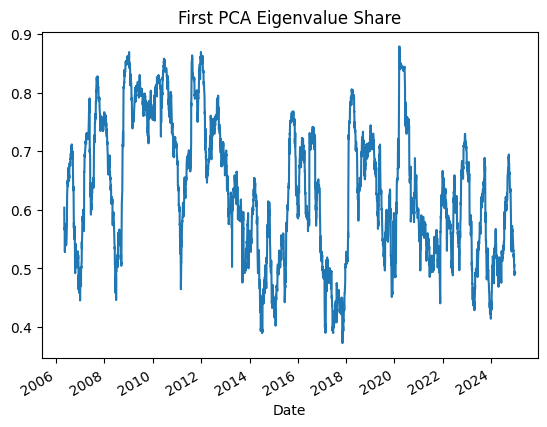

In [8]:
avg_corr.plot(title="Average Pairwise Correlation")
plt.show()

eigen_share.plot(title="First PCA Eigenvalue Share")
plt.show()

Regime Classification:

In [9]:
regimes = classify_regimes(
    avg_corr,
    config["low_regime_quantile"],
    config["high_regime_quantile"]
)

regimes.value_counts()

medium    1879
high      1409
low       1409
Name: count, dtype: int64

Portfolio Construction:

In [10]:
ew_weights = equal_weight_portfolio(returns)
mv_weights = mean_variance_portfolio(
    returns,
    config["risk_aversion"]
)
rp_weights = risk_parity_portfolio(returns)
vt_weights = volatility_targeted_portfolio(
    returns,
    config["vol_target"],
    config["trading_days"],
    avg_corr=avg_corr
)

pd.DataFrame({
    "Equal Weight": ew_weights,
    "Mean Variance": mv_weights,
    "Risk Parity": rp_weights,
    "Vol Targeted": vt_weights
})

TypeError: volatility_targeted_portfolio() got an unexpected keyword argument 'avg_corr'

Portfolio Returns:

In [ ]:
ew_ret = portfolio_returns(returns, ew_weights)
mv_ret = portfolio_returns(returns, mv_weights)
rp_ret = portfolio_returns(returns, rp_weights)
vt_ret = portfolio_returns(returns, vt_weights)

Cumulative Performance Plot:

In [ ]:
cumulative = pd.DataFrame({
    "Equal Weight": (1 + ew_ret).cumprod(),
    "Mean Variance": (1 + mv_ret).cumprod(),
    "Risk Parity": (1 + rp_ret).cumprod(),
    "Vol Targeted": (1 + vt_ret).cumprod(),
})

cumulative.plot(title="Cumulative Portfolio Performance")
plt.show()

Risk & Performance Summary:

In [ ]:
results = pd.DataFrame({
    "Equal Weight": {
        "Sharpe": sharpe_ratio(ew_ret),
        "Max Drawdown": max_drawdown(ew_ret),
        "Volatility": volatility(ew_ret),
    },
    "Mean Variance": {
        "Sharpe": sharpe_ratio(mv_ret),
        "Max Drawdown": max_drawdown(mv_ret),
        "Volatility": volatility(mv_ret),
    },
    "Risk Parity": {
        "Sharpe": sharpe_ratio(rp_ret),
        "Max Drawdown": max_drawdown(rp_ret),
        "Volatility": volatility(rp_ret),
    },
    "Vol Targeted": {
        "Sharpe": sharpe_ratio(vt_ret),
        "Max Drawdown": max_drawdown(vt_ret),
        "Volatility": volatility(vt_ret),
    },
})

results.T